<a href="https://colab.research.google.com/github/psilvaf/ictp-2021-lss-surveys/blob/main/Exercise_3_SNIa_MCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numerical Exercise 3: type Ia supernovae and MCMC
(thanks to Joe Zuntz for code basis)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad # will need for integration ('quadrature')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Here we will use actual SNIa data from the Pantheon collaboration to constrain the matter and cosmological-constant energy densities $\Omega_M$ and $\Omega_\Lambda$ in a non-flat universe. To do that we will use MCMC. 

As always - everything from scratch!


###First the usual preamble. 

In [ ]:

###########################################################################
### The block below is entirely optional; it just makes the plots look good
### You can copy it to all ipynb files that you do, or not, up to you
### requires the myplot_style.txt file that you upload as below
### (I will be providing that file)
###########################################################################

# figure size and resolution
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

# style file to make plots look nice (large labels etc)
from google.colab import files
src = list(files.upload().values())[0]
open('myplot_style.txt','wb').write(src)

# I will be providing this file - this is optional as I said
plt.style.use('myplot_style.txt')


###Then the usual comoving-distance function.

In [ ]:
def dist_integrand(z, Om, Ok, w):
    Ol = 1 - Om - Ok
    return 1.0/np.sqrt(Om*(1+z)**3 + Ol*(1+z)**(3*(1+w)) + Ok*(1+z)**2)

SMALL = 1.0e-5  # some small number, doesn't matter what

# this is really H0 r(z)!
def rz(z, Om, Ok, w):
    chi = quad(dist_integrand, 0, z, args=(Om, Ok, w))[0]
    if (Ok > SMALL):
        return np.sinh(np.sqrt(Ok)*chi) / np.sqrt(Ok) # open
    elif (Ok < -SMALL):
        return np.sin(np.sqrt(-Ok)*chi) / np.sqrt(-Ok) # closed
    else:
        return chi

Remember the equation that relates the observed apparent magnitude $m$ and the cosmological parameters is

$m(z) = 5\log_{10} (H_0 d_L(z)) + \mathcal{M}$

Code up the expression for $H_0 d_L(z, \Omega_M, \Omega_\Lambda)$, and then also $m(z, \Omega_M, \Omega_\Lambda)$.




In [ ]:
def H0_dL(z, Om, Ol):
  Ok = 1-Om-Ol
  w = -1.0  # hardcoded; won't change in this exercise
  return (1+z)*rz(z,Om,Ok,w)# FILL IN HERE  # remember our rz is actually H0*r

def m_theory(z, Om, Ol, scriptM):
  return 5*np.log10(H0_dL(z,Om,Ol))+ scriptM

### Now load up the *binned* SNIa data and its covariance

In [ ]:
#from google.colab import files
#uploaded = files.upload()

# alternative way; didn't smoothly work for me
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)

z_obs, m_obs = np.loadtxt("/content/drive/MyDrive/Colab Notebooks/ICTP-school/sn_data.txt").T
C = np.loadtxt("/content/drive/MyDrive/Colab Notebooks/ICTP-school/sn_cov.txt")

print('dimensions of data and Cov are', z_obs.shape, C.shape)

# we will need C^{-1} so take care of that right away
invC = np.linalg.inv(C)

dimensions of data and Cov are (40,) (40, 40)


#### Now plot the data along with (diagonal) error bars, and overplot with some model that we think is probably a good fit, such as $\Omega_M=1-\Omega_\Lambda=0.3$, $\mathcal{M}=23.8$.  

Text(0, 0.5, 'apparent magnitude')

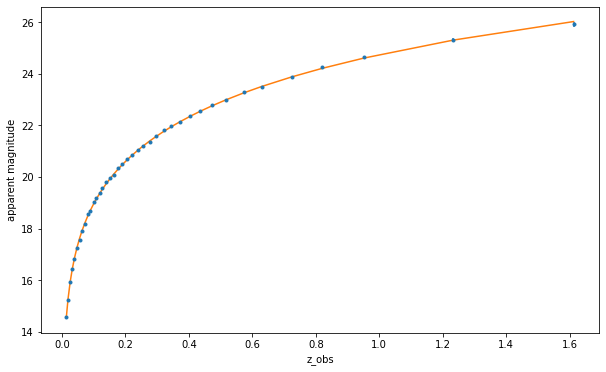

In [ ]:
plt.figure(figsize=(10,6))
plt.errorbar(z_obs, m_obs, yerr=np.sqrt(np.diagonal(C)), marker='.', ls='')

mth_array = [m_theory(z, 0.3, 0.7, 23.8) for z in z_obs]

plt.plot(z_obs, mth_array)
plt.xlabel('z_obs')
plt.ylabel('apparent magnitude')

###Is this model a good fit? How do you know?


Note that matrix multiplication in Python 3 is done with a '@', and you don't even need to worry about the transpose!

In [ ]:
chisq = (m_obs-mth_array)@invC@(m_obs-mth_array)
print(chisq)#chisq should be close to the number of data points

43.972906145817056


Now define a log-likelihood function (of the data, w.r.t. theory). Assume the likelihoood itself is Gaussian (remember, the Central Limit Theorem works in that favor):

$L = \displaystyle\frac{1}{2\pi |\det{C}|^{1/2}}\exp \left (-\frac{1}{2} (m-m^{\rm th})^T C^{-1} (m-m^{\rm th})\right )$



In [ ]:
# log (natural) likelihood given cosmo parameter vector p
def loglike(p):
    Om, Ol, scriptM = p
    if Om < 0:
        return -np.inf
    mth_array = [m_theory(z, Om, Ol, scriptM) for z in z_obs]
    d = (m_obs-mth_array)
    lnL = -0.5*d @ invC @ d #can ignore C because it doesn't depend on p
    return lnL

##Sampling

####Because we only have 3 cosmological parameters, our analysis could conceivably be done on a grid. However, most datasets in cosmology depend on more parameters, especially once you take into account any "nuisance" parametters (here, $\mathcal{M}$ is the only nuisance param)

####We will use the Metropolis-Hastings algorithm that we described in the lectures to explore this parameter space instead, to make it take a manageable time.

####We will first need a proposal function, which should returns a random jump from a current position in parameter space to one that is nearby.

###Write a proposal that adds a small Gaussian-distributed jump from the current point `p` in each direction, and returns the new point.  Since the parameters are all different they need different sized jumps. They should be ballpark size of (estimated final) errors in the corresponding parameters.


 
step in $\Omega_m: 0.01$

step in $\Omega_\Lambda: 0.01$

step in $\mathcal{M}: 0.025$

In [ ]:
#proposal function (for making a step in parameter space)
def propose(p):
    return p + np.random.normal(size=p.size) * np.array([0.01, 0.01, 0.025])

Now we will write a Metropolis-Hastings MCMC sampling process.

Write a code to perform the MH loop that we described in lectures, with these features:
- record the value of the new parameter set each time through the loop.
- record the likelihood each iteration.
- start from the point `[0.3, 0.7, 23.8]` (where you start doesn't matter too much)
- count the number of time the proposal is accepted.  If everything is working, about 25% (**very** roughly) of the jumps should be accepted in this case.
- run first for a few steps just to make sure things work, then for something like 10,000 steps, then at the very end for $N=100,000$ steps

Running this will take a few minutes - you might want to print something out every 1000 samples to give you an idea of progress. First start with very few steps just too make sure it works.


In [ ]:
# First make an array describing the starting point of the iteration
p = np.array([0.3, 0.7, 23.8])
Lp = loglike(p)

# number of steps, plus define couple of arrays
N = 100000   # number of total attempts to walk
chain = np.zeros((N, 3))
likes = np.zeros(N)

# start the array of weights; make it 1 element long and append below
weights = [0]
param_corresp_weight= np.array([[0, 0, 0]])  # just initializing, had to declare first dummy one

##################
# Main MCMC loop
##################
acc=0
for i in range(N):
    if i%1000 == 0:  # print every 1000th step or something
        print(i)
    # new possible point and its likelihood
    q = propose(p)
    Lq = loglike(q)
    ##################################
    # Metropolis acceptance criterion
    ### if accepted:
    ##################################    
    if (Lq-Lp)>0 or Lq - Lp > np.log(np.random.uniform()):
        p = q
        Lp = Lq
        # count accepts
        acc += 1
        ##################################
        ### computing the "weight"
        ##################################
        # add (append) weight array element for new model and set it to one
        weights.append(1)
        # and write corresponding parameter values
        param_corresp_weight = np.vstack([param_corresp_weight, p])
    ##################################
    ### if rejected:
    ##################################    
    else: # if rejected, increase weight by one
      index = len(weights)-1
      weights[index] += 1

    # store next point, whether it's the same or not
    chain[i] = p
    # store the log likelihood
    likes[i] = Lp

# Done. Print acceptance fraction
print('Acceptance rate is', acc/N)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
Acceptance rate is 0.19741


Plot the value of each parameter throughout the chain.  Comment on the performance of the proposal.

I told you ahead of time what good step sizes in parameters will be. After you run this plot, go back to the propsal above, increase (or decrease) one of the steps by factor of 10, and rerun. How does the acceptance rate change, and how do plots below now look?

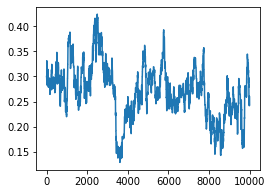

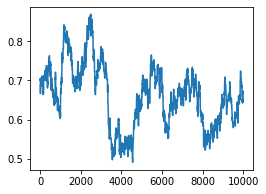

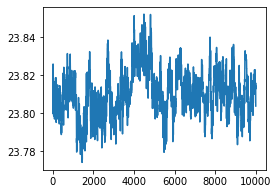

In [ ]:
# write your code here
for i in range(3):
    plt.figure(figsize=(4,3))
    plt.plot(chain[:,i])

####Make a scatter plot of omega_matter versus omega_lambda for the full chain.Use the likelihood value as the color of each point, and size=1 for each.

Text(0, 0.5, '$\\Omega_\\Lambda$')

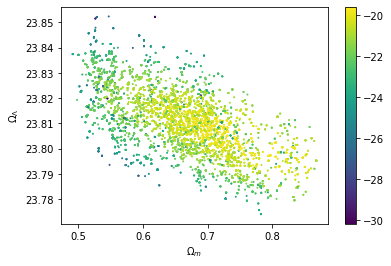

In [ ]:
plt.scatter(chain[:,1], chain[:,2], s=1, c=likes[:])
plt.colorbar()
plt.xlabel("$\Omega_m$")
plt.ylabel("$\Omega_\Lambda$")

#### But that's actually not what you want - remember, you want to do analyze weights (how many attempts were rejected before accecptance for a given model). 

Text(0, 0.5, '$\\Omega_\\Lambda$')

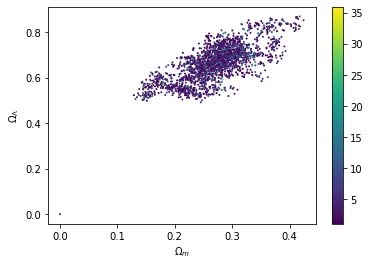

In [ ]:
plt.scatter(param_corresp_weight[:,0], param_corresp_weight[:,1], s=1, c=weights[:])
plt.colorbar()
plt.xlabel("$\Omega_m$")
plt.ylabel("$\Omega_\Lambda$")

#### But that's actually not what you want either - you want to find 68\%, 96% etc percentiles of the weights - that is, sum up the weights from highest and go down until you hit 68% etc of the total sum.

##(To be continued)